# Read and plot the image


In [118]:
%matplotlib inline
from pylab import *
import skimage
from skimage import io
from skimage import exposure
import cv2
import numpy as np
import os
import copy
from skimage import filters
from skimage import feature
from skimage.transform import hough_line, hough_line_peaks
from skimage.color import rgb2gray
from skimage import morphology

(3648, 5472, 3)


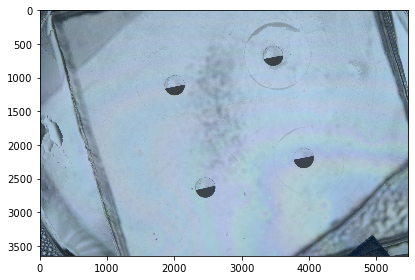

In [115]:
#read the image
directory = './SiO2/test'
filename= 'Basler_acA5472-17uc__23975371__20230614_173718909_0022.tiff'
img_input_full = io.imread(f"{directory}/{filename}") #dtype=float)
#show the image
io.imshow(img_input_full)
print(img_input_full.shape)
plt.show()

# Test find circles on single image 

In [119]:
def compute_angle(img,x,y):
    grayscale = rgb2gray(img)
    margin = 90
    crop = img[y - margin:y + margin, x - margin:x + margin]
    crop= morphology.area_opening(crop, area_threshold=500, connectivity=2)
    crop= morphology.area_closing(crop, area_threshold=500, connectivity=2)
    edge = feature.canny(grayscale, sigma=1)
    h, theta, d = hough_line(edge)
    bestH, bestTheta, bestD = skimage.transform.hough_line_peaks(h, theta, d)
    anglebest = 90-rad2deg(bestTheta)
    av_angle=np.round(mean(anglebest),2)
    errorangle=np.round(std(anglebest)/sqrt(len(anglebest)),2)
    print(av_angle,errorangle)
    return av_angle, errorangle

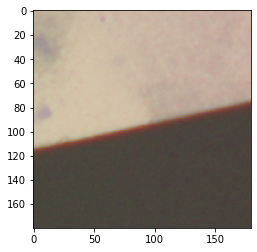

In [120]:
image = cv2.imread(f"{directory}/{filename}")
cropped = image[0:3400, 1000:5000]
margin = 90
crop = cropped[2634 - margin:2634 + margin, 1451 - margin:1451 + margin]
crop= morphology.area_opening(crop, area_threshold=500, connectivity=2)
crop= morphology.area_closing(crop, area_threshold=500, connectivity=2)
plt.imshow(crop)

[[1451 2634  149]
 [2456  683  148]
 [2910 2198  148]
 [ 999 1119  149]]
21.79 9.88
21.79 9.88
21.79 9.88
21.79 9.88


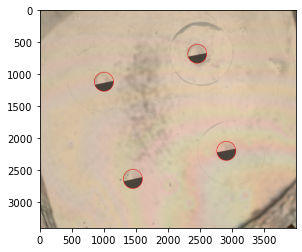

In [121]:
image = cv2.imread(f"{directory}/{filename}")
cropped = image[0:3400, 1000:5000]
output = cropped.copy()
img = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
# Find circles
circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1.3, 100)
# If some circle is found
if circles is not None:
   # Get the (x, y, r) as integers
   circles = np.round(circles[0, :]).astype("int")
   print(circles)
   # loop over the circles
   for (x, y, r) in circles:
      cv2.circle(output, (x, y), r, (255, 0, 0), 6)
      compute_angle(output,x,y)
# show the output image
plt.imshow(output)

# Functions for distance calculation

In [71]:
def distance(x1,x2,y1,y2):
    return round(sqrt((x2-x1)**2+(y2-y1)**2))

def distanceFromOtherImg(coordsCircleSource, arrayCoordsOthersCircles):
    dists = []
    for otherCircle in arrayCoordsOthersCircles:
        dist = distance(coordsCircleSource[0], otherCircle[0], coordsCircleSource[1], otherCircle[1])
        dists.append(dist)
    return dists

In [102]:
# Images to be analyzed
L = os.listdir(directory)
# Loop over all files in a given directory sorted by name
images ={}
for i, fn in enumerate(sorted(os.listdir(directory))):
    #read the image
    # print(f"{directory}/{fn}")
    image = cv2.imread(f"{directory}/{fn}")
    #crop the image
    crop = image[0:3400,1000:5000]
    output = crop.copy()
    
    img = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    # Find circles
    circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1.3, 100)
    # If some circle is found
    if circles is not None:
        # Get the (x, y, r) as integers
        circles = np.round(circles[0, :]).astype("int")
        # print(circles)
        images['img_' + str(i)] = {"circles": circles, "dists": [], "angles":[], "errorangle":[]}
        # loop over the circles
        for (x, y, r) in circles:
            cv2.circle(output, (x, y), r, (255, 0, 0), 6)
            theta = compute_angle(output,x,y)
            images['img_' + str(i)]["angles"].append(theta[0])
            images['img_' + str(i)]["errorangle"].append(theta[1])
print(images)

12.770949720670401 0.45083487361595276
12.770949720670401 0.45083487361595276
12.625698324022357 0.47695525046054693
12.625698324022357 0.47695525046054693
12.354349561053485 0.2659977940288252
12.354349561053485 0.2659977940288252
12.354349561053485 0.2659977940288252
12.354349561053485 0.2659977940288252
21.787709497206713 9.880532276842073
21.787709497206713 9.880532276842073
21.787709497206713 9.880532276842075
21.787709497206713 9.880532276842075
73.44506517690876 10.294362133377179
75.80575848732273 10.416106830256817
75.80575848732273 10.416106830256817
74.3463687150838 9.725862608686047
80.55466879489225 9.58156396718285
80.55466879489225 9.58156396718285
80.55466879489225 9.581563967182852
80.55466879489225 9.581563967182852
{'img_0': {'circles': array([[1279, 2480,  150],
       [2670,  781,  148],
       [1150,  904,  148],
       [2794, 2358,  151]]), 'dists': [], 'angles': [12.770949720670401, 12.770949720670401, 12.625698324022357, 12.625698324022357], 'errorangle': [0.45

In [72]:
# Calcul de la distance pour chaque cercle à t donné avec les coordonnées des cercles de l'image à t+dt
def assignDists(imgsDict):
    images = copy.deepcopy(imgsDict)
    
    for i, img in enumerate(images):
        if i+1 < len(images):
            
            for currentCircle in images[img]["circles"]: 
                nextImgCircles = images['img_'+ str(i+1)]["circles"]
                images[img]["dists"].append(distanceFromOtherImg(currentCircle, nextImgCircles)) 
            # print(len(images[img]["dists"]))
    return images

test = assignDists(images)
print(test)


4
4
4
4
{'img_0': {'circles': array([[1279, 2480,  150],
       [2670,  781,  148],
       [1150,  904,  148],
       [2794, 2358,  151]]), 'dists': [[1489, 2173, 112, 1587], [1621, 123, 2209, 1510], [133, 1421, 1668, 2189], [2195, 1650, 1449, 98]]}, 'img_1': {'circles': array([[1065, 1006,  149],
       [2560,  725,  148],
       [1359, 2559,  149],
       [2853, 2280,  148]]), 'dists': [[1673, 1428, 2197, 131], [2208, 112, 1514, 1610], [119, 2173, 1592, 1484], [1446, 1646, 100, 2188]]}, 'img_2': {'circles': array([[1451, 2634,  149],
       [2456,  683,  148],
       [2910, 2198,  148],
       [ 999, 1119,  149]]), 'dists': [[2181, 1492, 1598, 116], [115, 1610, 1508, 2206], [1652, 2192, 105, 1448], [1429, 127, 2194, 1669]]}, 'img_3': {'circles': array([[2347,  645,  149],
       [ 942, 1232,  150],
       [2959, 2105,  149],
       [1550, 2694,  150]]), 'dists': [[1512, 1614, 114, 2207], [2194, 128, 1430, 1671], [99, 2196, 1650, 1449], [1596, 1494, 2182, 118]]}, 'img_4': {'circles': 

# Area opening and closing

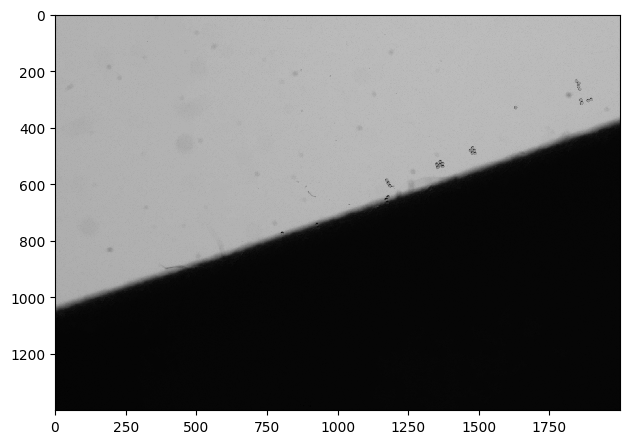

In [83]:
from skimage import morphology

#area opening of the image
#removes all bright structures of an image with a surface smaller than area_threshold
image_o= morphology.area_opening(cropped, area_threshold=500, connectivity=2)
#show the image
io.imshow(image_o)
plt.show()

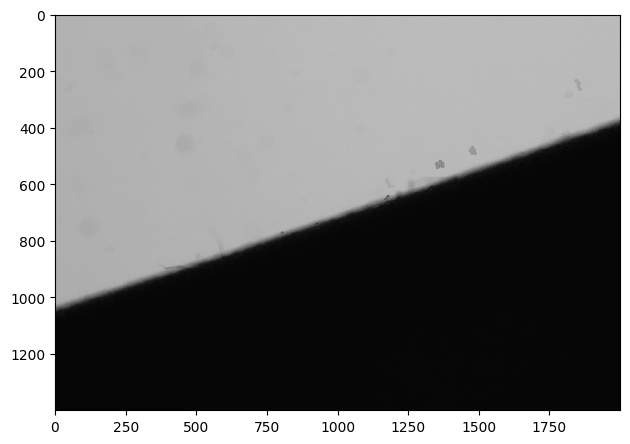

In [84]:
#area closing of the image
#removes all dark structures of an image with a surface smaller than area_threshold
image_c= morphology.area_closing(image_o, area_threshold=500, connectivity=2)
#show the image
io.imshow(image_c)
plt.show()

In [85]:
image=image_c

# Second method: edge detector

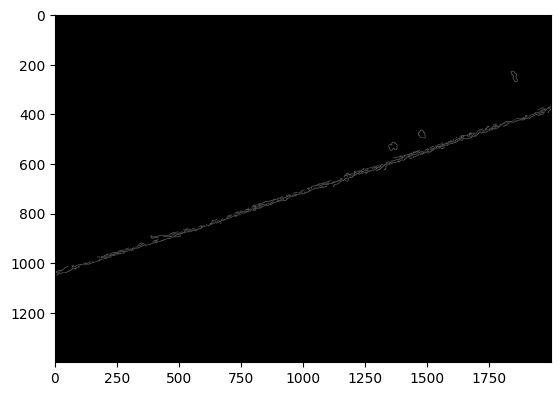

In [86]:
from skimage import filters
from skimage import feature

#edge operators
#edge = filters.scharr(image)
#edge = filters.sobel(image)""

#Canny edge detector
edge = feature.canny(image, sigma=1)

#io.imshow(edge_scharr, cmap=plt.cm.gray)

imshow(edge, cmap ='gray')
plt.show()

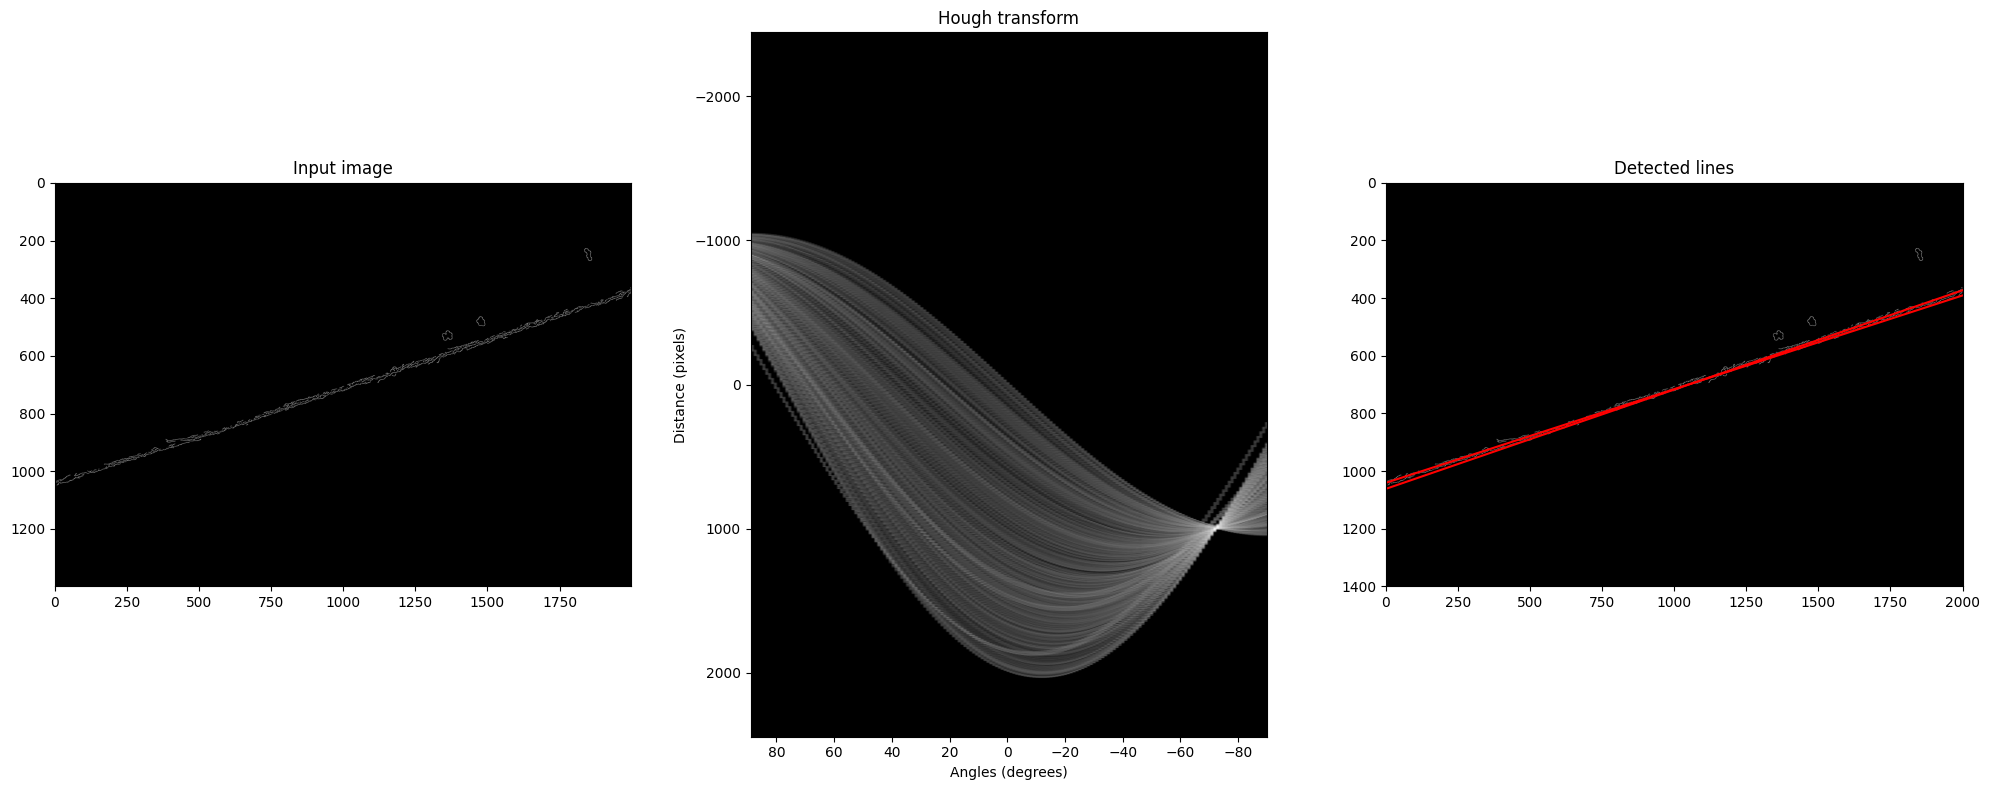

angle, standard error of angle:
18.499999999999993 0.35355339059326873


In [87]:
from skimage.transform import hough_line, hough_line_peaks

#image to be transformed
image_h=edge
#image_h=binary_global

#straight-line Hough transform
#The origin is the top left corner of the original image
#X and Y axis are horizontal and vertical edges respectively. 
h, theta, d = hough_line(image_h)

plt.figure(figsize=(20, 8))

plt.subplot(131)
plt.imshow(image_h, cmap=plt.cm.gray)
plt.title('Input image')

plt.subplot(132)
plt.imshow(np.log(1 + h),
           extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]),
                   d[-1], d[0]],
           cmap=plt.cm.gray, aspect=1/20)
plt.title('Hough transform')
plt.xlabel('Angles (degrees)')
plt.ylabel('Distance (pixels)')

plt.subplot(133)
plt.imshow(image_h, cmap=plt.cm.gray)
rows, cols = image_h.shape
#angle made by the line with the origin 

for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - cols * np.cos(angle)) / np.sin(angle)
    plt.plot((0, cols), (y0, y1), '-r') 
plt.axis((0, cols, rows, 0))
plt.title('Detected lines')

plt.tight_layout()

plt.show()

bestH, bestTheta, bestD = skimage.transform.hough_line_peaks(h, theta, d)

print('angle, standard error of angle:')
anglebest = 90-rad2deg(bestTheta)
print(mean(anglebest),std(anglebest)/sqrt(len(anglebest)))